## MTH9871 HW1
### Xinyi(Krystal) Lin

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def payout(r, X, w, K, T):
    
    """
    Calculate the payoff for a basket option.
    
    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.
        
    Returns:
        P (float): Payoff value.
    """
    B = 0.0
    N = len(X)
    for i in range(N):
        B += w[i] * X[i]
    
    x = B - K
    D = np.exp(-r*T)
    P = D * max(x, 0.0)
    return P

def fdm(r, X, w, K, T, eps):
    
    """
    Calculate the gradient for a basket option using Finite Difference Method.
    
    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.
        eps (float): epsilon for FDM.
        
    Returns:
        P_d (list): Full gradient.
    """
    
    Nd = 1 + len(X)
    P_d = np.zeros(Nd) 
    
    # Compute gradient with respect to r (risk-free rate) using FDM
    P_d[0] = (payout(r + eps, X, w, K, T) - payout(r, X, w, K, T)) / eps
    
    # Compute gradients with respect to each asset price in X using FDM
    for i in range(1, Nd):
        X[i-1] += eps
        price_new = payout(r, X, w, K, T)
        X[i-1] -= eps
        price = payout(r, X, w, K, T)
        P_d[i] = (price_new - price) /  eps
    
    return P_d

def tangent_helper(r, X, r_d, X_d, w, K, T):
    """
    Calculate the payoff and its gradient for a basket option using tangent for one component.

    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        r_d (float): Gradient with respect to r.
        X_d (list): Gradients with respect to each X[i].
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.

    Returns:
        tuple: (P, P_d), where
            P (float): Payoff value.
            P_d (float): Gradient of the payoff with respect to r and X.
    """
    # Initialize variables
    B = 0.0
    B_d = 0.0

    # Calculate B and its derivative B_d
    B = np.dot(w, X)
    B_d = np.dot(w, X_d)

    # Calculate x and its derivative x_d
    x = B - K
    x_d = B_d

    # Calculate D and its derivative D_d
    D = np.exp(-r * T)
    D_d = -T * D * r_d

    # Calculate P and its gradient P_d
    P = D * max(x, 0.0)
    P_d = 0.0

    if x > 0:
        P_d = D_d * x + D * x_d

    return P, P_d


def tangent(r, X, w, K, T):
    """
    Calculate the payoff and full gradient for a basket option using tangent by calling tangent_helper N + 1 times.

    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.

    Returns:
        tuple: (P, P_d), where
            P (float): Payoff value.
            P_d (float): Gradient of the payoff with respect to r and X.
    """   
    N = len(X)
    P_d = np.zeros(N  + 1)
    X_d = np.zeros(N)
    
    # Compute gradient with respect to r (risk-free rate) using tangent mode
    P, P_d[0] = tangent_helper(r, X, 1, X_d, w, K, T)
    
    # Compute gradient with respect to each asset price in X using tangent mode
    for i in range(N):
        X_d[i] = 1
        P, P_d[i+1] = tangent_helper(r, X, 0, X_d, w, K, T)
        X_d[i] = 0    
        
    return P, P_d


def rd_Xd(N):
    """
    Helper function to generate gradient vector for tangent multimode

    Parameters:
        N (int): number of underlying assets

    Returns:
        tuple: (r_d, X_d), where
            r_d (list): gradient for r.
            X_d (list): gradient for X.
    """
    r_d = np.zeros(N + 1)
    r_d[0] = 1
    X_d = np.eye(N, N + 1, k=1)
    return r_d, X_d


def tangent_multimode(r, X, w, K, T):
    """
    Calculate the payoff and its full gradient for a basket option using multimode tangent methodology.
    
    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.
        
    Returns:
        tuple: (P, P_d), where
            P (float): Payoff value.
            P_d (ndarray): Full gradient (size N+1).
    """
    N = len(X)
    Nd = N + 1

    # Get r_d and X_d efficiently
    r_d, X_d = rd_Xd(N)

    # Calculate B and B_d using NumPy vectorized operations
    B = np.dot(w, X)  # Weighted sum of X
    B_d = np.dot(w, X_d)  # Weighted sum for derivatives

    # Calculate x and x_d
    x = B - K
    x_d = B_d

    # Calculate D and D_d
    D = np.exp(-r * T)
    D_d = -T * D * r_d

    # Calculate P and P_d
    P = D * max(x, 0.0)
    P_d = D_d * x + (D * x_d) if x > 0 else np.zeros(Nd)
    
    return P, P_d


def adjoint(r, X, w, K, T, P_b=1.0):
    """
    Calculate the payoff and its adjoint gradients for a basket option.

    Parameters:
        r (float): Risk-free rate.
        X (list): Values of the N underlying assets.
        w (list): Weights of the assets in the basket.
        K (float): Strike price.
        T (float): Time to maturity.
        P_b (float): Adjoint variable for the payoff (default is 1.0).

    Returns:
        tuple: (P, r_b, X_b), where
            P (float): Payoff value.
            r_b (float): Adjoint gradient with respect to the risk-free rate.
            X_b (list): Adjoint gradients with respect to the asset prices.
    """
    # Forward sweep
    B = 0.0
    N = len(X)
    for i in range(N):
        B += w[i] * X[i]
    
    x = B - K
    D = np.exp(-r * T)
    P = D * max(x, 0.0)
    
    # Backward sweep
    D_b = max(x, 0.0) * P_b
    x_b = 0.0
    if x > 0:
        x_b = D * P_b
    
    r_b = -D * T * D_b
    B_b = x_b
    
    X_b = [0.0] * N
    for i in range(N):
        X_b[i] = w[i] * B_b
    
    return P, r_b, X_b



###  Example with All Methods

In [3]:
r = 0.05  
X = [99, 103, 104, 100]  
w = [0.4, 0.3, 0.2, 0.1]  
K = 100  
T = 1  

r_d, X_d = rd_Xd(len(X))
payoff_tangent, gradient_tangent = tangent(r, X, w, K, T)
payoff_tangent_multi, gradient_tangent_multi = tangent_multimode(r, X, w, K, T)
payoff_adjoint, r_gradient, X_gradients = adjoint(r, X, w, K, T)
print("Payoffs: ", payoff_tangent, payoff_tangent_multi,  payoff_adjoint)
print("Gradient Tangent:", gradient_tangent)
print("Gradient Tangent Multimode:", gradient_tangent_multi)
print("Gradient Adjoint:", r_gradient, X_gradients)
print('Gradient FDM:', fdm(r, X, w, K, T, eps = 1e-10))

Payoffs:  1.2365982518509255 1.2365982518509255 1.2365982518509255
Gradient Tangent: [-1.23659825  0.38049177  0.28536883  0.19024588  0.09512294]
Gradient Tangent Multimode: [-1.23659825  0.38049177  0.28536883  0.19024588  0.09512294]
Gradient Adjoint: -1.2365982518509255 [0.38049176980028565, 0.2853688273502142, 0.19024588490014283, 0.09512294245007141]
Gradient FDM: [-1.23659749  0.3805245   0.28536062  0.19032997  0.0951661 ]


In [4]:
r = 0.05  
X = [99, 103, 104]  
w = [0.4, 0.3, 0.3]  
K = 100  
T = 0.5

r_d, X_d = rd_Xd(len(X))
payoff_tangent, gradient_tangent = tangent(r, X, w, K, T)
payoff_tangent_multi, gradient_tangent_multi = tangent_multimode(r, X, w, K, T)
payoff_adjoint, r_gradient, X_gradients = adjoint(r, X, w, K, T)
print("Payoffs: ", payoff_tangent, payoff_tangent_multi,  payoff_adjoint)
print("Gradient Tangent:", gradient_tangent)
print("Gradient Tangent Multimode:", gradient_tangent_multi)
print("Gradient Adjoint:", r_gradient, X_gradients)
print('Gradient FDM:', fdm(r, X, w, K, T, eps = 1e-10))

Payoffs:  1.658026850448168 1.658026850448168 1.658026850448168
Gradient Tangent: [-0.82901343  0.39012396  0.29259297  0.29259297]
Gradient Tangent Multimode: [-0.82901343  0.39012396  0.29259297  0.29259297]
Gradient Adjoint: -0.829013425224084 [0.39012396481133305, 0.2925929736084998, 0.2925929736084998]
Gradient FDM: [-0.82901241  0.39015902  0.29258596  0.29258596]


##### Comparing the gradients for tangent, tangent multimode and adjoint, we see that they all matched the gradient computed from FDM (up to numerical precision).

###  Performance Chart 

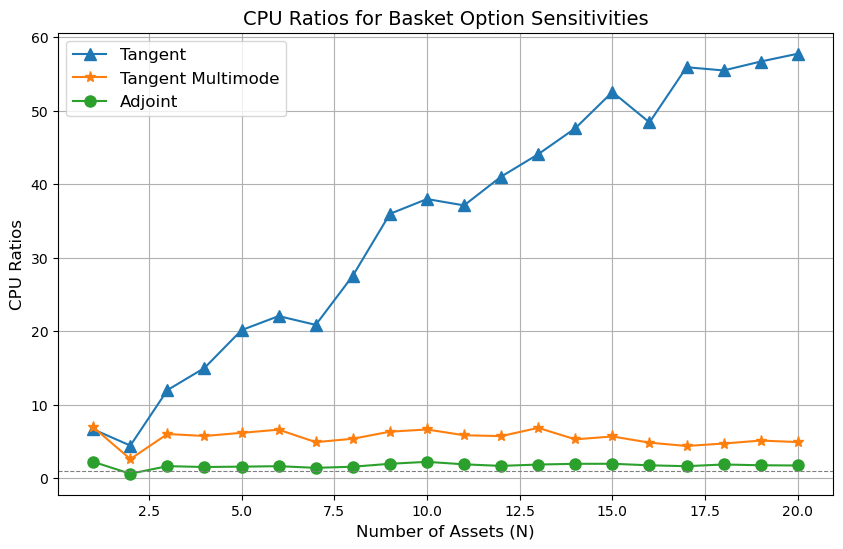

In [5]:
# Timing ratios for functions
Ns = range(1, 21)
ratios_tangent = []
ratios_tangent_multimode = []
ratios_adjoint = []
iterations = 1000

for N in Ns:
    X = [100 + i for i in range(N)]
    w = [1 / N] * N
    
    # Measure time for payout
    start = time.perf_counter()
    for i in range(iterations):
        payout(r, X, w, K, T)
    time_payout = time.perf_counter() - start
    
    # Measure time for tangent
    start = time.perf_counter()
    for i in range(iterations):
        tangent(r, X, w, K, T)
    time_tangent = time.perf_counter() - start
    ratios_tangent.append(time_tangent / time_payout)
    
    # Measure time for tangent_multimode
    start = time.perf_counter()
    for i in range(iterations):
        tangent_multimode(r, X, w, K, T)
    time_tangent_multimode = time.perf_counter() - start
    ratios_tangent_multimode.append(time_tangent_multimode / time_payout)
    
    # Measure time for adjoint
    start = time.perf_counter()
    for i in range(iterations):
        adjoint(r, X, w, K, T)
    time_adjoint = time.perf_counter() - start
    ratios_adjoint.append(time_adjoint / time_payout)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(Ns, ratios_tangent, '^-', label='Tangent', markersize=8)
plt.plot(Ns, ratios_tangent_multimode, '*-', label='Tangent Multimode', markersize=8)
plt.plot(Ns, ratios_adjoint, 'o-', label='Adjoint', markersize=8)
plt.axhline(y=1, color='gray', linestyle='--', linewidth=0.8)
plt.title('CPU Ratios for Basket Option Sensitivities', fontsize=14)
plt.xlabel('Number of Assets (N)', fontsize=12)
plt.ylabel('CPU Ratios', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

##### From the performance chart, we see that adjoint is most efficient followed by tangent multimode, and lastly tangent with N + 1 calls. The tangent multimode is also able to achieve a roughly constant CPU ratios using numpy's vectorized operations.